In [1]:
from PIL import Image
import math
import numpy as np
import matplotlib.pyplot as plt 
import random

In [2]:
# XYZ Reference values
# Illuminant = D65 and Observer = 2 for sRGB
referenceX = 95.047
referenceY = 100.000
referenceZ = 108.883

In [3]:
# General functions

# Opens image as numpy array
def openImg(filename):
    im = Image.open(filename)
    mode = im.mode
    im = np.array(im, dtype=np.uint8)
    if (mode == "RGBA"):
        im = im[:, :, :3]
    return im

# Takes RGB values -> XYZ -> Lab
def rgb2lab(rgb):
    # sRGB to XYZ
    R = rgb[0] / 255
    G = rgb[1] / 255
    B = rgb[2] / 255
    
    if R > 0.04045:
        R = math.pow(((R + 0.055) / 1.055), 2.4)
    else:
        R /= 12.92
    if G > 0.04045:
        G = math.pow(((G + 0.055) / 1.055), 2.4)
    else:
        G /= 12.92
    if B > 0.04045:
        B = math.pow(((B + 0.055) / 1.055), 2.4)
    else:
        B /= 12.92
        
    R *= 100
    G *= 100
    B *= 100
    
    X = (R * 0.4124) + (G * 0.3576) + (B * 0.1805)
    Y = (R * 0.2126) + (G * 0.7152) + (B * 0.0722)
    Z = (R * 0.0193) + (G * 0.1192) + (B * 0.9505)
    
    # XYZ to Lab
    X /= referenceX
    Y /= referenceY
    Z /= referenceZ
    
    if X > 0.008856:
        X = math.pow(X, 1/3)
    else:
        X = (7.787 * X) + (16 / 116)
    if Y > 0.008856:
        Y = math.pow(Y, 1/3)
    else:
        Y = (7.787 * Y) + (16 / 116)
    if Z > 0.008856:
        Z = math.pow(Z, 1/3)
    else:
        Z = (7.787 * Z) + (16 / 116)
        
    L = (116 * Y) - 16
    a = 500 * (X - Y)
    b = 200 * (Y - Z)
    
    return [L, a, b]

# Takes Lab values -> XYZ -> RGB
def lab2rgb(Lab, bound = 1):
    # Lab to XYZ
    Y = (Lab[0] + 16) / 116
    X = Lab[1] / 500 + Y
    Z = Y - Lab[2] / 200
    
    if math.pow(Y, 3) > 0.008856:
        Y = math.pow(Y, 3)
    else:
        Y = (Y - 16 / 116) / 7.787
    if math.pow(X, 3) > 0.008856:
        X = math.pow(X, 3)
    else:
        X = (X - 16 / 116) / 7.787
    if math.pow(Z, 3) > 0.008856:
        Z = math.pow(Z, 3)
    else:
        Z = (Z - 16 / 116) / 7.787
        
    X *= referenceX
    Y *= referenceY
    Z *= referenceZ
    
    # XYZ to sRGB
    X /= 100
    Y /= 100
    Z /= 100
    
    R = X *  3.2406 + Y * -1.5372 + Z * -0.4986
    G = X * -0.9689 + Y *  1.8758 + Z *  0.0415
    B = X *  0.0557 + Y * -0.2040 + Z *  1.0570
    
    if R > 0.0031308:
        R = 1.055 * math.pow(R, 1/2.4) - 0.055
    else:
        R *= 12.92
    if G > 0.0031308:
        G = 1.055 * math.pow(G, 1/2.4) - 0.055
    else:
        G *= 12.92
    if B > 0.0031308:
        B = 1.055 * math.pow(B, 1/2.4) - 0.055
    else:
        B *= 12.92
        
    R *= 255
    G *= 255
    B *= 255
    
    if bound:
        R = round(min(max(R, 0), 255))
        G = round(min(max(G, 0), 255))
        B = round(min(max(B, 0), 255))
    
    return [R, G, B]

# Calculate the distance between two colors in Lab space
def getLabDistance(Lab1, Lab2):
    L1 = Lab1[0]
    a1 = Lab1[1]
    b1 = Lab1[2]
    L2 = Lab2[0]
    a2 = Lab2[1]
    b2 = Lab2[2]
    L = L1-L2
    a = a1-a2
    b = b1-b2
    return math.sqrt((L*L)+(a*a)+(b*b))

# Calculate phi
def getPhi(r, sigma):
    return math.exp(-math.pow(r,2) / (2 * math.pow(sigma,2)))

In [4]:
class Palette:
    def __init__(self, k = 5):
        self.k = k
        
        self.orig = np.zeros((self.k,3))
        self.edit = np.zeros((self.k,3))
        self.curr = np.zeros((self.k,3))
        
        self.C_b = np.zeros((self.k,3))
        self.Lambda = np.zeros((self.k,self.k))
        
        self.sigma = 0
        
    # Calculate sigma
    def setSigma(self):
        count = 0
        for i in range(self.k):
            for j in range(i, self.k):
                self.sigma += getLabDistance(self.orig[i],self.orig[j])
                count += 1
        self.sigma /= count
        
    # Calculate lambda
    def setLambda(self):
        for c in range(self.k):
            for r in range(self.k):
                dist = getLabDistance(self.orig[c], self.orig[r])
                self.Lambda[c][r] = 1 / (1 + dist)
        
    # Set color of the original palette and calculate sigma and lambda values
    def setOrigPalette(self, palette):
        for i in range(self.k):
            self.orig[i] = palette[i]
            self.edit[i] = palette[i]
            self.curr[i] = palette[i]
        self.setSigma()
        self.setLambda()
            
    # Updates the palette when a color is modified, maintaining monotonicity in luminance
    def setColorPalette(self, p, RGB):
        if p >= self.k:
            raise IndexError('index out of range')
        Lab = rgb2lab(RGB)
        self.curr[p] = Lab
        self.edit[p] = Lab
        for i in range(p+1, self.k):
            self.curr[i][0] = min(self.curr[i][0], self.curr[i-1][0])
        for i in range(p-1, -1, -1):
            self.curr[i][0] = max(self.curr[i][0], self.curr[i+1][0])

In [5]:
# Color Palette Selection

# Put all colors in image into 16x16x16 bins and calculate the average color in each bin
def binLab(image):
    bins = np.zeros((16*16*16,4))
    for c in range(len(image)):
        for r in range(len(image[0])):
            Lab = rgb2lab(image[c][r])
            Lab = np.array([Lab[0], Lab[1], Lab[2], 1])
            binL = int(Lab[0]//16)
            bina = int(Lab[1]//16)
            binb = int(Lab[2]//16)
            bindex = binL * 16 * 16 + bina * 16 + binb
            bins[bindex] += [Lab[0], Lab[1], Lab[2], 1]
            
    for i in range(len(bins)):
         if bins[i][3] != 0:
            Lab = bins[i][:3]/bins[i][3]
            Lab = [Lab[0], Lab[1], Lab[2], bins[i][3]]
            bins[i] = Lab
    bins = bins[np.all(bins != 0, axis=1)]
    return bins

def visbinLab(image):
    binsL = np.zeros(16)
    binsa = np.zeros(16)
    binsb = np.zeros(16)
    for c in range(len(image)):
        for r in range(len(image[0])):
            Lab = rgb2lab(image[c][r])
            Lab = np.array([Lab[0], Lab[1], Lab[2], 1])
            binL = int(Lab[0]//16)
            bina = int(Lab[1]//16)
            binb = int(Lab[2]//16)
            binsL[binL] += 1
            binsa[bina] += 1
            binsb[binb] += 1
    return binsL, binsa, binsb

def visbinRGB(image):
    binsR = np.zeros(16)
    binsG = np.zeros(16)
    binsB = np.zeros(16)
    for c in range(len(image)):
        for r in range(len(image[0])):
            RGB = image[c][r]
            RGB = np.array([RGB[0], RGB[1], RGB[2], 1])
            binR = int(RGB[0]//16)
            binG = int(RGB[1]//16)
            binB = int(RGB[2]//16)
            binsR[binR] += 1
            binsG[binG] += 1
            binsB[binB] += 1
    return binsR, binsG, binsB
    
# Use a deterministic k-means to generate palette colors
def kmeans(k, bins):
    # Choosing the initial palette
    palette = np.zeros((k+1,4))
    init_bins = bins.copy()
    for p in range(k):
        max_p = 0
        for bindex in range(len(init_bins)):
            if init_bins[bindex][3] > init_bins[max_p][3]:
                max_p = bindex
        palette[p] = init_bins[max_p]
        
        p_lab = palette[p][:3]
        for bindex in range(len(init_bins)):
            c_lab = init_bins[bindex][:3]
            lab_dist = getLabDistance(p_lab,c_lab)
            sigma = 80
            init_bins[bindex][3] *= (1 - math.exp(-math.pow(lab_dist,2)/math.pow(sigma,2)))
            
    # Proceed with the rest of the k-means algorithm
    stable = False
    while not stable:
        new_palette = np.zeros((k+1,4))
        for bindex in range(len(bins)):
            min_dist = float('inf')
            min_p = -1
            for p in range(k+1):
                p_lab = palette[p]
                c_lab = bins[bindex][:3]
                curr_dist = getLabDistance(p_lab,c_lab)
                if min_dist > curr_dist:
                    min_dist = curr_dist
                    min_p = p
            if min_p != k:
                total_bin = bins[bindex][:3] * bins[bindex][3]
                total_bin = [total_bin[0], total_bin[1], total_bin[2], bins[bindex][3]]
                new_palette[min_p] += total_bin
            
        # Find new average color for each palette entry
        for p in range(k+1):
            if new_palette[p][3] != 0:
                Lab = new_palette[p][:3]/new_palette[p][3]
                new_palette[p] = [Lab[0], Lab[1], Lab[2], new_palette[p][3]]
            matching = palette[p][:3] == new_palette[p][:3]
            matching = matching.all()
            if p == 0:
                stable = matching
            stable = stable and matching
        palette = new_palette.copy()
    
    # Sort the palette by the L value
    tmp_palette = palette.copy()[:k]
    len_tmp = len(tmp_palette)
    for p in range(k):
        max_L = float('-inf')
        max_i = k+1
        for i in range(len_tmp):
            if max_L < tmp_palette[i][0]:
                max_L = tmp_palette[i][0]
                max_i = i
        palette[p] = tmp_palette[max_i]
        tmp_palette[max_i] = tmp_palette[len_tmp-1]
        len_tmp -= 1
    return palette[:, :3]

In [6]:
# Color Transfer Functions

# Transform L of a pixel based on modified palette
def transferL(Lab, palette):
    L = 0
    Lab_black = rgb2lab([0,0,0])
    Lab_white = rgb2lab([255,255,255])
    closest_dist = np.zeros(2)
    closest_p = np.zeros(2, dtype=int)
    
    lab_dist_b = getLabDistance(Lab, Lab_black)
    lab_dist_w = getLabDistance(Lab, Lab_white)
    if lab_dist_b > lab_dist_w:
        closest_dist = [lab_dist_w, lab_dist_b]
        closest_p = [-2, -1]
    else:
        closest_dist = [lab_dist_b, lab_dist_w]
        closest_p = [-1, -2]
    
    for i in range(palette.k):
        lab_dist = getLabDistance(Lab, palette.curr[i])
        if (Lab == palette.curr[i]).all():
            return Lab[0]
        if lab_dist < closest_dist[0]:
            closest_dist[1] = closest_dist[0]
            closest_p[1] = closest_p[0]
            closest_dist[0] = lab_dist
            closest_p[0] = i
        elif lab_dist < closest_dist[1]:
            closest_dist[1] = lab_dist
            closest_p[1] = i
    
    if closest_p[0] == -1:
        curr_L1 = Lab_black[0]
        orig_L1 = Lab_black[0]
    elif closest_p[0] == -2:
        curr_L1 = Lab_white[0]
        orig_L1 = Lab_white[0]
    else:
        curr_L1 = palette.curr[closest_p[0]][0]
        orig_L1 = palette.orig[closest_p[0]][0]
    
    if closest_p[1] == -1:
        curr_L2 = Lab_black[0]
        orig_L2 = Lab_black[0]
    elif closest_p[1] == -2:
        curr_L2 = Lab_white[0]
        orig_L2 = Lab_white[0]
    else:
        curr_L2 = palette.curr[closest_p[1]][0]
        orig_L2 = palette.orig[closest_p[1]][0]
        
    if orig_L1 == orig_L2:
        L = curr_L1
    else:
        L = ((Lab[0] - orig_L1) / (orig_L2 - orig_L1)) * (curr_L2 - curr_L1) + curr_L1
    return L

# Check if value is in gamut
def isInGamut(Lab):
    RGB = lab2rgb(Lab, 0)
    for i in range(len(RGB)):
        if RGB[i] < 0 or RGB[i] > 255:
            return False
    return True

# Find where ray Lab2 -> Lab1 intersects gamut using binary search
def boundaryIntersection(Lab1, Lab2, min_t = 0, max_t = 300):
    position = Lab1
    direction = Lab2 - Lab1
    midpoint = 0.5 * (max_t - min_t)
    while midpoint > 1:
        guess = position + midpoint * direction
        if isInGamut(guess):
            min_t += midpoint
        else:
            max_t -= midpoint
        midpoint = 0.5 * (max_t - min_t)
    return guess
    
# Find where ray C' -> C meets gamut boundary
def getPaletteBounds(palette):
    for i in range(palette.k):
        C = palette.orig[i]
        C_prime = palette.curr[i]
        palette.C_b[i] = boundaryIntersection(C, C_prime)
    return palette

# Transform a and b of a pixel based on modified palette
def transferab(Lab, palette):
    x = Lab
    
    f = np.zeros((palette.k,3))
    w = np.zeros((palette.k))
    phi = np.zeros(palette.k)
    Lambda = np.zeros((palette.k,palette.k))
    
    for i in range(palette.k):
        C = palette.orig[i]
        C_prime = palette.curr[i]
        C_b = palette.C_b[i] # where C -> C' intersect RGB bounds
        x_o = x + C_prime - C
        if (isInGamut(x)):
            x_b = boundaryIntersection(x, x_o) # where parallel ray where x intersects bounds
        else:
            x_b = boundaryIntersection(C_prime, x_o) # ray from C' -> xo intersects bounds
        if (C_b == C).all():
            t = 0
        else:
            t = min(1, getLabDistance(x_b, x)/getLabDistance(C_b, C))
        t *= getLabDistance(C_prime, C)
        x_prime = x + t * (x_b - x)
        f[i] = x_prime
        
        phi[i] = getPhi(getLabDistance(x, C), palette.sigma)
        w[i] = sum(palette.Lambda[i] * phi[i])

    res = 0
    for i in range(palette.k):
        res += w[i] * f[i]
    
    return res

In [7]:
# Update Image
def updateImage(im, palette):
    palette = getPaletteBounds(palette)
    res = im.copy()
    for c in range(len(im)):
        for r in range(len(im[0])):
            x = rgb2lab(im[c][r])
            L = transferL(x, palette)
            ab = transferab(x, palette)
            res[c][r] = lab2rgb([L, ab[1], ab[2]])
    return res

In [8]:
visp_lab = np.zeros((6,5,3))

k = 5
palette = Palette(k)
im = openImg('sample-1.jpg')
bins = binLab(im)

palette.setOrigPalette(kmeans(palette.k, bins))
visp_lab[0] = palette.orig.copy()

palette.setColorPalette(0, [255, 255, 255])
visp_lab[1] = palette.curr.copy()

palette.setColorPalette(1, [50, 0, 0])
visp_lab[2] = palette.curr.copy()

palette.setColorPalette(2, [10, 90, 70])
visp_lab[3] = palette.curr.copy()

palette.setColorPalette(3, [116, 28, 83])
visp_lab[4] = palette.curr.copy()

palette.setColorPalette(4, [0, 0, 0])
visp_lab[5] = palette.curr.copy()

new_im = updateImage(im, palette)

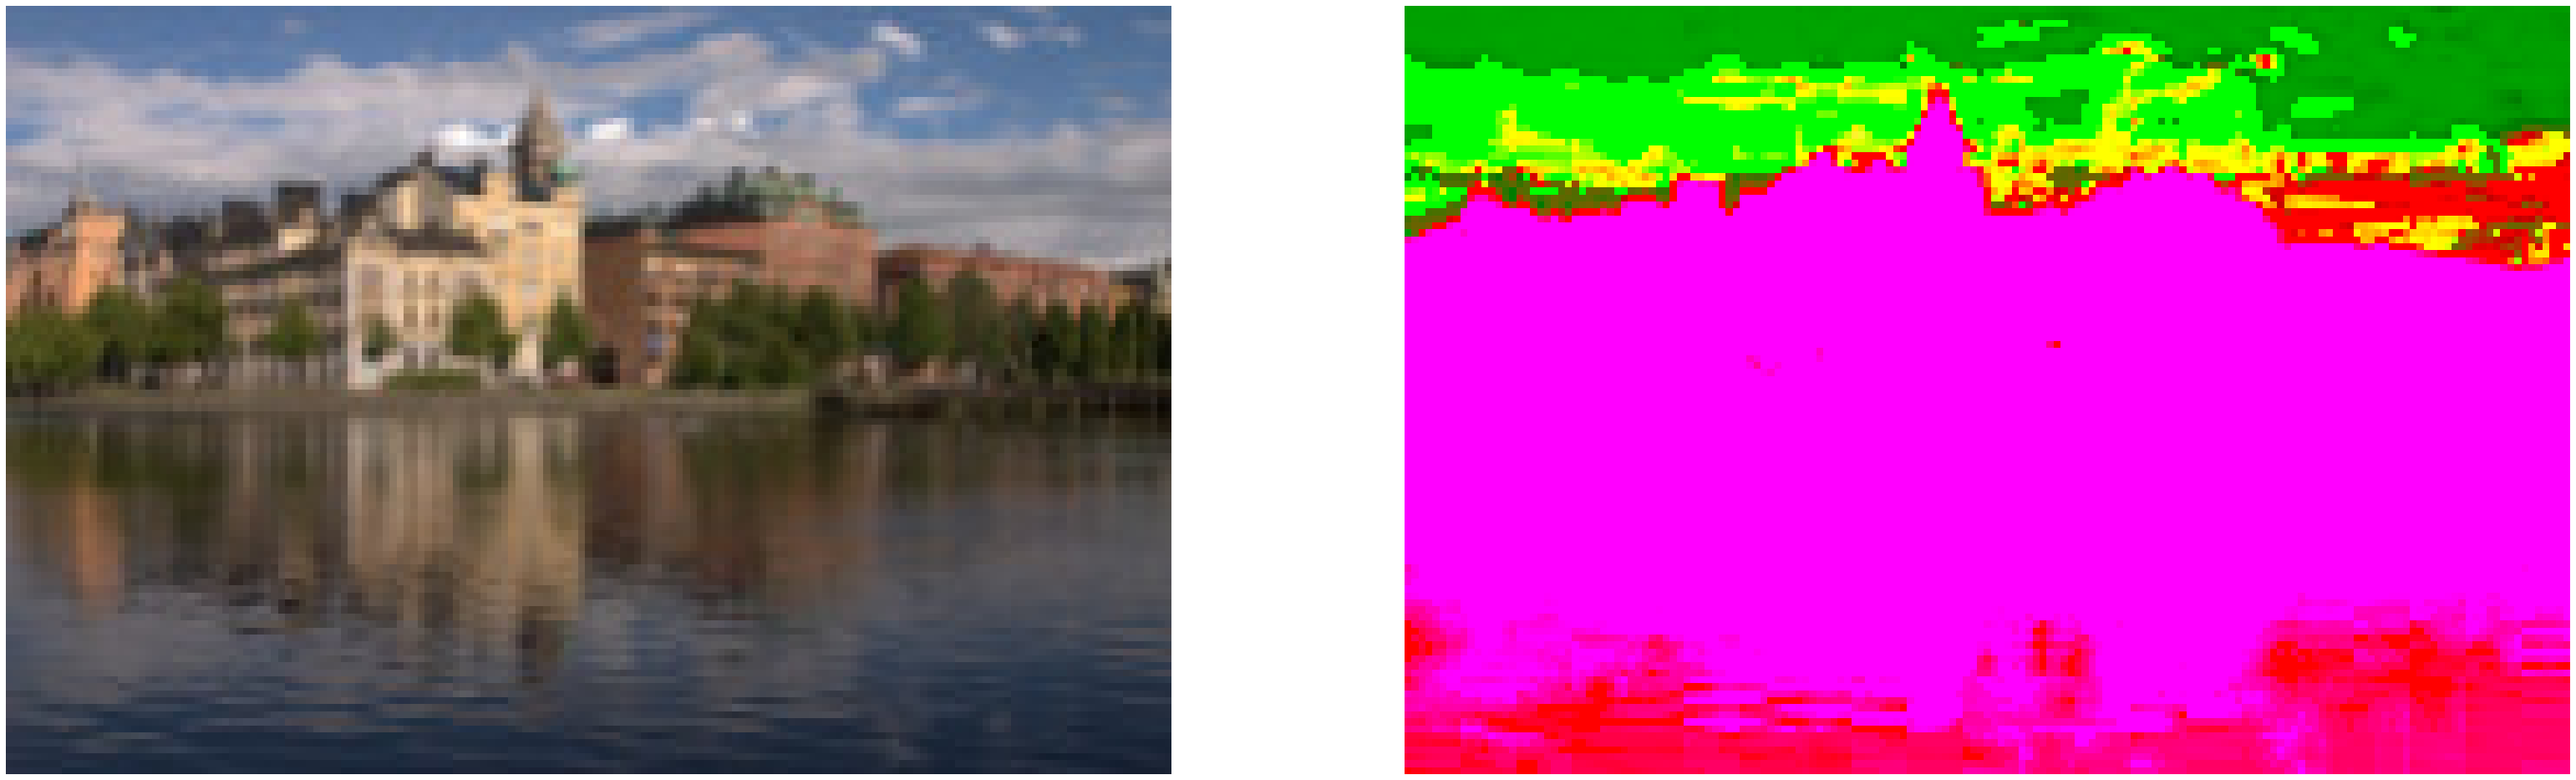

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(len(im)//2,len(im[0])//2))
ax[0].imshow(im)
ax[1].imshow(new_im)

ax[0].set_axis_off()
ax[1].set_axis_off()

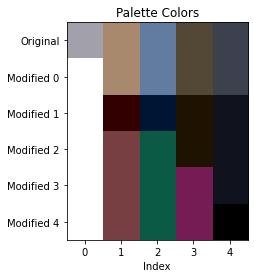

In [10]:
visp_rgb = np.zeros((6,5,3), dtype=np.uint8)
ylabels = ["","Original","","","","",""]
for j in range(6):
    for i in range(5):
        visp_rgb[j][i] = lab2rgb(visp_lab[j][i])
        if j >= 1:
            ylabels[j+1] = "Modified {}".format(j-1)
    
fig, ax = plt.subplots()
ax.imshow(visp_rgb)
ax.set_title("Palette Colors")
ax.set_yticklabels(ylabels)
ax.set_xlabel("Index")
plt.show()

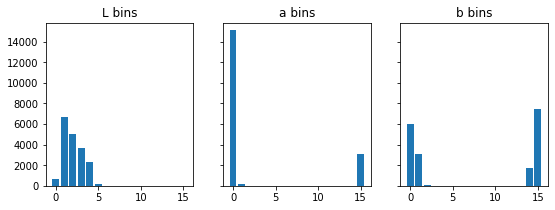

In [11]:
binsL, binsa, binsb = visbinLab(im)
bins_no = np.arange(16)

fig, ax = plt.subplots(1, 3, figsize=(9, 3), sharey=True)

ax[0].bar(bins_no, binsL, label="L")
ax[1].bar(bins_no, binsa, label="a")
ax[2].bar(bins_no, binsb, label="b")

ax[0].set_title("L bins")
ax[1].set_title("a bins")
ax[2].set_title("b bins")
plt.show()

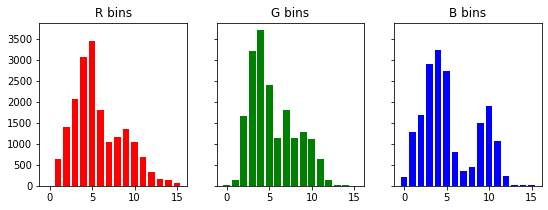

In [12]:
binsR, binsG, binsB = visbinRGB(im)
bins_no = np.arange(16)

fig, ax = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
ax[0].bar(bins_no, binsR, color="red")
ax[1].bar(bins_no, binsG, color="green")
ax[2].bar(bins_no, binsB, color="blue")

ax[0].set_title("R bins")
ax[1].set_title("G bins")
ax[2].set_title("B bins")

plt.show()

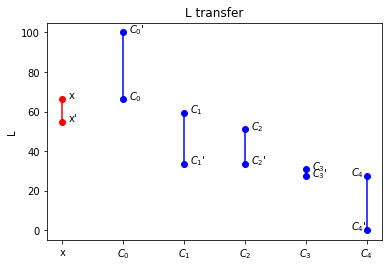

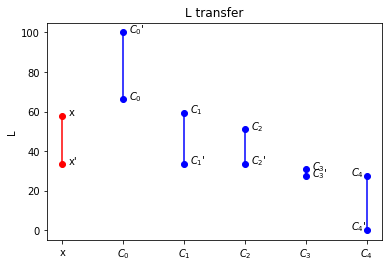

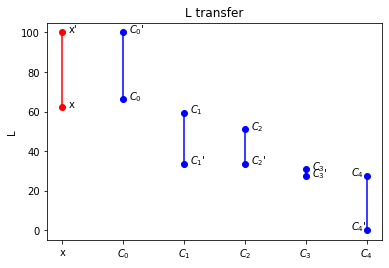

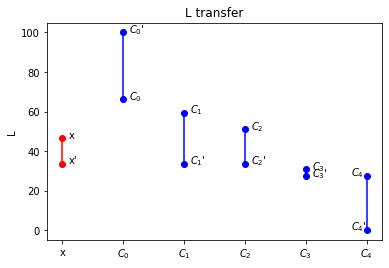

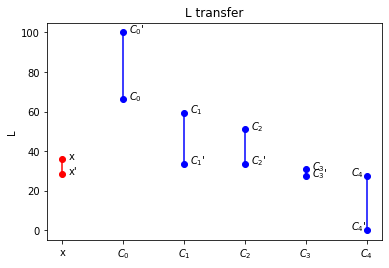

In [13]:
palette_lines = np.zeros((5,2,2))
for i in range(5):
    palette_lines[i][0] = [i, i]
    palette_lines[i][1] = [palette.orig[i][0], palette.curr[i][0]]

for i in range(5):
    fig, ax = plt.subplots()

    ax.set_title("L transfer")
    ax.set_ylabel("L")
    xlabels = ["" for i in range(k+2)]
    xlabels[1] = "x"

    c_rgb = [random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)]
    c_lab = rgb2lab(c_rgb)
    c_lab_prime = transferL(c_lab, palette)
    ax.plot([-1, -1], [c_lab[0],c_lab_prime], 'bo', linestyle="-", color="red")
    ax.text(-1+0.1, c_lab[0]-0.1, "x")
    ax.text(-1+0.1, c_lab_prime+0.1, "x'")
    for i in range(k):
        ax.plot(palette_lines[i][0], palette_lines[i][1], 'bo', linestyle="-")
        xlabels[i+2] = "$C_{}$".format(i)
        if i != k-1:
            ax.text(palette_lines[i][0][0]+0.1, palette_lines[i][1][0]-0.1, "$C_{}$".format(i))
            ax.text(palette_lines[i][0][1]+0.1, palette_lines[i][1][1]+0.1, "$C_{}$\'".format(i))
        else:
            ax.text(palette_lines[i][0][0]-0.25, palette_lines[i][1][0]-0.1, "$C_{}$".format(i))
            ax.text(palette_lines[i][0][1]-0.25, palette_lines[i][1][1]+0.1, "$C_{}$\'".format(i))
    ax.set_xticklabels(xlabels)
    plt.show()

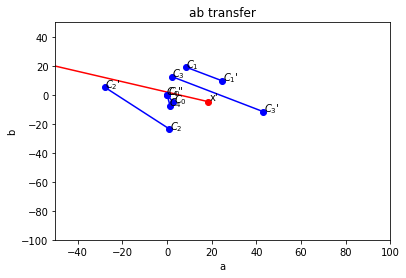

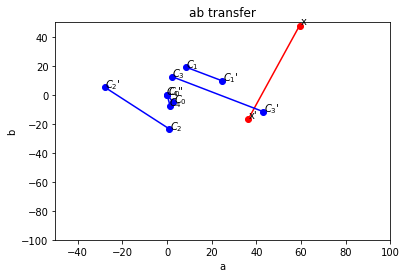

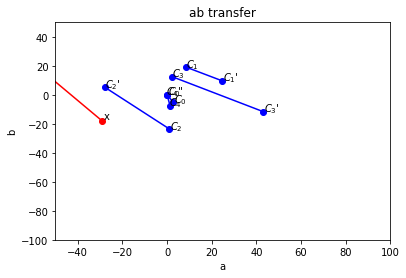

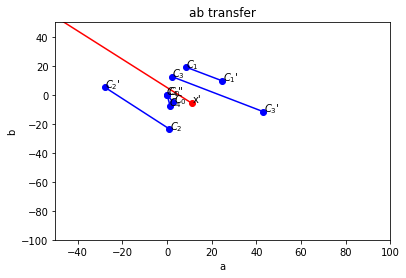

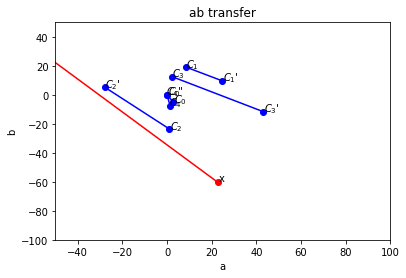

In [14]:
palette_lines = np.zeros((5,2,2))
for i in range(5):
    palette_lines[i][0] = [palette.orig[i][1], palette.curr[i][1]]
    palette_lines[i][1] = [palette.orig[i][2], palette.curr[i][2]]
    
for y in range(5):
    fig, ax = plt.subplots()
    ax.set_ylim(-100,50)
    ax.set_xlim(-50,100)
    ax.set_title("ab transfer")
    ax.set_ylabel("b")
    ax.set_xlabel("a")
    c_rgb = [random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)]
    c_lab = rgb2lab(c_rgb)
    c_lab_prime = transferab(c_lab, palette)
    ax.plot([c_lab[1], c_lab_prime[1]], [c_lab[2], c_lab_prime[2]], 'bo', linestyle="-", color="red")
    if (c_lab[1] > -50 and c_lab[1] < 100 and c_lab[2] > -100 and c_lab[2] < 50):
        ax.text(c_lab[1]+0.5, c_lab[2]+1, "x")
    if (c_lab_prime[1] > -50 and c_lab_prime[1] < 100 and c_lab_prime[2] > -100 and c_lab_prime[2] < 50):
        ax.text(c_lab_prime[1]+0.5, c_lab_prime[2]+1, "x'")
    for i in range(5):
        ax.plot(palette_lines[i][0], palette_lines[i][1], 'bo', linestyle="-")
        if i != k-1:
            ax.text(palette_lines[i][0][0]+0.2, palette_lines[i][1][0]-0.1, "$C_{}$".format(i))
            ax.text(palette_lines[i][0][1]+0.2, palette_lines[i][1][1]+0.1, "$C_{}$\'".format(i))
        else:
            ax.text(palette_lines[i][0][0]-0.25, palette_lines[i][1][0]-0.1, "$C_{}$".format(i))
            ax.text(palette_lines[i][0][1]-0.25, palette_lines[i][1][1]+0.1, "$C_{}$\'".format(i))
    plt.show()